In [69]:
library(ggplot2)
library(data.table)
library(vegan)
library(dplyr)
library(stringr)

setwd('/data6/Angelo/alexcc/AngeloStrainsPaper/manuscript_materials/soil_popgen/notebooks')

In [11]:
## 1. Read in annotations for all data
s = read.csv('../data_tables/samples.txt', sep='\t') # sample data
sm=read.csv('../data_tables/antismash_genes.tsv', sep='\t') # antismash annotations
sm_domain = sm[which(sm$Domain != 'false'),]
r = read.csv('../data_tables/ribosomal.ql', sep='\t') # ribosomal protein annotations

In [9]:
## 2. Read in nucleotide diversity data for each gene in each sample
## this step takes a while
files = Sys.glob("../data/nucleotide_diversity/*.tsv")

i = 0;
for (f in files){
    r = read.csv(f, sep='\t')
#     print(f)
    if (i > 0){
        d = rbind(d,r)
    }
    else {
        d = r
        print("step 1")
    }
    i = i + 1
}

[1] "uh oh "


In [18]:
split_d = str_split_fixed(d$sample, ":", 2)
d$genome = split_d[,1]
d$sample = split_d[,2]

In [44]:
## separate by type
d$type = 'sample'
d$type[which(d$sample %in% unique(s$plot))] = 'plot'
d$type[which(d$sample %in% unique(s$replicate))] = 'replicate'
d$type[which(d$sample %in% unique(s$block))] = 'block'
d$type[which(d$sample == 'all')] = 'meadow'
d = d[which(d$type != 0),]
d$bgc = 'All'
d[which(d$gene %in% sm_domain$ORF),]$bgc = 'BGC'
d[which(d$gene %in% r$feature),]$bgc = 'Ribosomal'

In [45]:
## Summarize mean nucleotide diversity by each sample or category
data = d
data <- data %>% 
    group_by(sample, genome, type, bgc) %>% 
    summarize(mean = mean(pi))

In [46]:
## Assign new genome names
names = read.csv('../data_tables/names.txt', sep="\t")
data_named = merge(x= data, y=names, by.x='genome', by.y='old', all.x=TRUE)
type_levels <- c('sample', 'replicate', 'plot', 'block', 'meadow')
data_named$type <- factor(data_named$type, levels = type_levels)

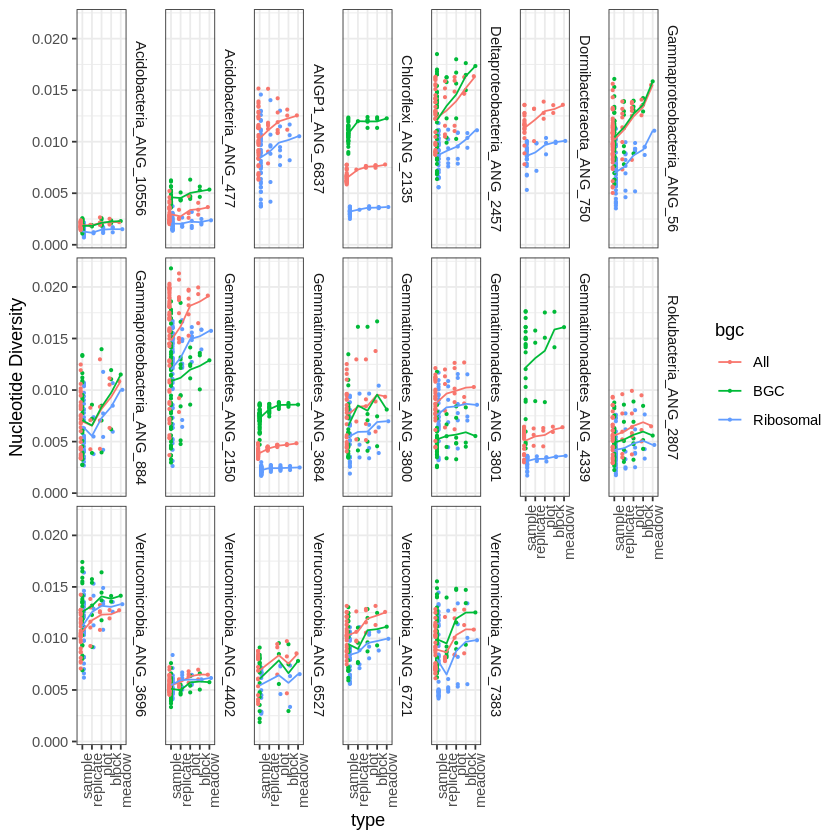

In [146]:
# pdf(file='Fig3b.pdf', width=12, height=8)
ggplot(data = data_named, aes(y=mean, x=type, group = bgc, color=bgc)) +
    geom_point(size = 0.5, position=position_dodge(width=0.5)) +
    theme_bw() + theme(strip.background = element_blank(),
  strip.text.x = element_blank()) + 
 stat_summary(geom = "line", fun.y = mean, )+facet_wrap(~new, nrow=3, strip.position = 'right') + 
ylab("Nucleotide Diversity") +
theme(axis.text.x = element_text(angle = 90, hjust = 1))
# dev.off()

Warning message:
“Removed 233 rows containing non-finite values (stat_boxplot).”

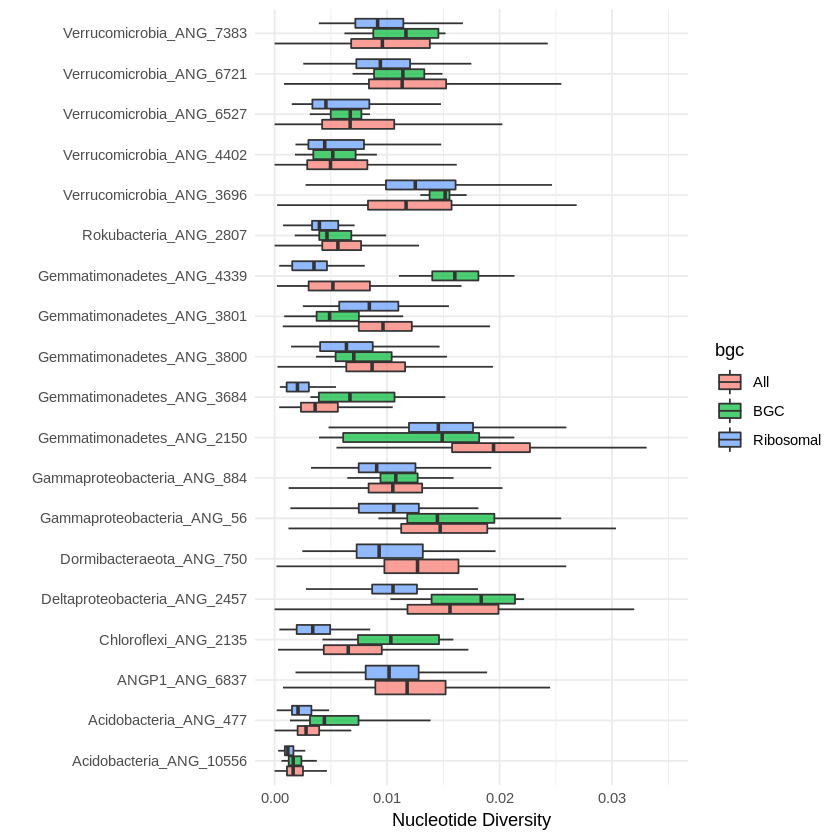

In [145]:
# pdf(file = 'Fig3a.pdf')
total = d[which(d$type == 'meadow'),]
total = merge(x= total, y=names, by.x='genome', by.y='old', all.x=TRUE)

ggplot(total, aes(y=pi, x=new, fill=bgc)) + 
geom_boxplot(outlier.shape=NA, outlier.size=0, alpha=0.7) + 
coord_flip() + theme_minimal() + xlab("") + ylab("Nucleotide Diversity") + ylim(0,0.035)
# dev.off()

In [ ]:
## statistical tests

for (g in unique(total$genome)){
    g_data = total[which(total$genome == g),]
    g_data1 = g_data[which(g_data$bgc != 'Ribosomal'),]
    t.test(g_data1$pi ~ g_data1$bgc)
    g_data2 = g_data[which(g_data$bgc != 'BGC'),]
    t.test(g_data2$pi ~ g_data2$bgc)
}

In [70]:
annotations = fread('../data_tables/pfam_annotations.txt', sep="\t")

In [80]:
head(g_data)

,genome,gene,pi,coverage,length_with_coverage,sample,type,bgc,new
,<chr>,<fct>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<fct>
57495,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_2,0.0025709041,456.3568,1707,all,meadow,All,Acidobacteria_ANG_10556
57496,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_3,0.0007741251,491.6209,831,all,meadow,All,Acidobacteria_ANG_10556
57497,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_4,0.0018081707,470.0546,3978,all,meadow,All,Acidobacteria_ANG_10556
57498,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_5,0.0038431560,436.2462,597,all,meadow,All,Acidobacteria_ANG_10556
57499,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_6,0.0015305315,438.3589,1956,all,meadow,All,Acidobacteria_ANG_10556
57500,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_7,0.0014180882,479.3107,177,all,meadow,All,Acidobacteria_ANG_10556


In [101]:
## most diverse proteins in each genome
library(dplyr)

diverse_proteins <- data.frame('orf' = numeric(),'pi'=numeric(),'length'=numeric(),'genome'=numeric(),
                               'pfams'=numeric(),
                      stringsAsFactors = FALSE)

for (g in unique(total$genome)){
    g_data = total[which(total$genome == g & total$length_with_coverage > 400),]
    g_data = merge(x = g_data, y=annotations, by.x='gene', by.y='orf')
    g_data = top_n(g_data, n = 3, wt=pi)
    for (row in 1:nrow(g_data)){
        diverse_proteins[nrow(diverse_proteins) + 1,] = list(as.character(g_data[row,'gene']), as.numeric(g_data[row,'pi']),
           g_data[row,'length_with_coverage'],as.character(g_data[row,'new']), as.character(g_data[row,'pfams']))
    }
}

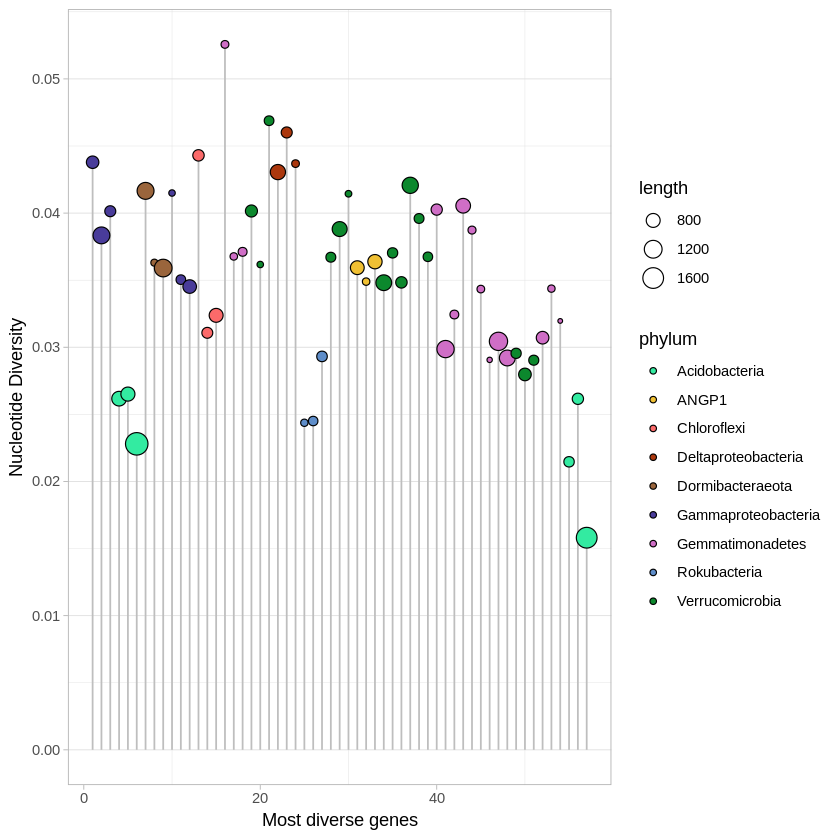

In [142]:
# pdf(file = 'Fig3c.pdf', width=11, height=4)

diverse_proteins$phylum = as.factor(gsub(diverse_proteins$genome, pattern = '_.*', replacement = ''))
diverse_proteins$num = 1:nrow(diverse_proteins)

ggplot(diverse_proteins, aes(x=num, y=pi)) +
  geom_segment( aes(x=num, xend=num, y=0, yend=pi), color="grey") +
  geom_point( aes(fill=phylum, size=length), shape=21) +
  theme_light() +
  theme(
    panel.grid.major.x = element_blank(),
  ) +
  xlab("Most diverse genes") +
  ylab("Nucleotide Diversity") + 
scale_fill_manual(values = c('#33eba1', '#f0c033', '#fb6a6a', '#ab370d', '#9a653c', '#493c9a', '#cf6ec6', '#5e8dc9', '#0c882d'))
# dev.off()

In [137]:
diverse_proteins

orf,pi,length,genome,pfams,phylum
<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>
14_0903_02_20cm_scaffold_3020_2,0.04379092,687,Gammaproteobacteria_ANG_56,Glucosamine_iso,Gammaproteobacteria
14_0903_02_20cm_scaffold_41505_2,0.03833887,1092,Gammaproteobacteria_ANG_56,DJ-1_PfpI,Gammaproteobacteria
14_0903_02_20cm_scaffold_44_7,0.04013933,589,Gammaproteobacteria_ANG_56,SoxG,Gammaproteobacteria
14_0903_05_40cm_scaffold_10_53,0.02617014,867,Acidobacteria_ANG_477,DDE_Tnp_IS1595,Acidobacteria
14_0903_05_40cm_scaffold_11207_9,0.02651121,813,Acidobacteria_ANG_477,Bac_transf,Acidobacteria
14_0903_05_40cm_scaffold_760_22,0.02280390,1881,Acidobacteria_ANG_477,"GATase_7,Asn_synthase,GATase_6",Acidobacteria
14_0903_09_40cm_scaffold_14312_7,0.04165672,1101,Dormibacteraeota_ANG_750,DUF222,Dormibacteraeota
14_0903_09_40cm_scaffold_2406_7,0.03630544,432,Dormibacteraeota_ANG_750,UPF0054,Dormibacteraeota
14_0903_09_40cm_scaffold_791_58,0.03590404,1188,Dormibacteraeota_ANG_750,DUF222,Dormibacteraeota
